In [181]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
params ={'axes.labelsize' : 20,
         'axes.titlesize' : 20,
         'xtick.labelsize' : 15,
         'ytick.labelsize' : 15,}
plt.rcParams.update(params)

### ITERATIVE methods for Ptychographic phase retrieval

In [218]:
def get_rho(obj, mask_data_list, measured_data_list):
    '''calculates the error function rho(obj) and its derivatives for a given set of object and experiment setup data

    Parameters
    ----------
    rho : error function
         =rho(obj)
    Drho : function
        Derivative of rho(obj).
    obj : vector (Signal object)
        At which to calculate the obj 
    mask_data_list : 2d numpy array
        list of the mask functions shifted by some detuning parameter used to get the different copies of data
    measured_data_list : 2d numpy array
        list of Intensity(t) signals measured at the detector

    Returns
    -------
    obj_n : vector (Signal object)
        
    '''
    
    L = len(mask_data_list) #total number of masks used
    
    Drho = np.zeros_like(mask_data_list[0])  #complex vector Nx1
    #Drho_2 = np.zeros_like(mask_data_list[0]) 



    rho = 0 #scalar

    for i in range(L): #iterates over all different probe positions i

            #for the i-th copy of the measured signal

            Q = np.diag(mask_data_list[i])
            Q_star = np.diag(np.conj(mask_data_list[i]))
            z= np.fft.ifft(Q.dot(obj)) # z_i = invF.Q_i.obj_n #fake image function

            b = np.sqrt(measured_data_list[i]) #b_i = sqrt(I_i)
            r = abs(z)-b #residuals
            
            

            rho+=0.5*LA.norm(r)**2 # rho (for nth iteration) = 0.5*||r||^2  
            Drho+= 0.5*Q_star.dot( 
                                     np.fft.fft(  
                                                 np.diag(z/abs(z)).dot(
                                                                        r) 
                                                 )
                                    ) # = J_star*r

    return rho,Drho



### Simulating experimental data

In [219]:
#function to generate a spectrum with some energy detuning:

def get_spectrum(E_detuning): #in keV
    #1. take sample spectrum
    #2. take detuned masked spectrum
    #3. convolute and get the image at the detector
    #4. GET A LIST of images with different detunings
    
    
    
    h = 4.135*10**(-6) #neV.s 
    #sample spectrum
    Gamma = 4.66 #neV
    N = 100 # number of points in a DFT
    w= np.linspace(-100,100,N) #in units of Gamma
    
    sample_w_0= 0 
    sample_fwhm_0= 20 #neV

    sample_amp = 1/(1+4*(w-sample_w_0)**2/sample_fwhm_0**2) #normalised
    sample_phase = math.pi/(1+np.exp(-2*(w-sample_w_0)))


    #mask spectrum
    mask_w_0= 0 #(keV)
    mask_fwhm_0= 20 #neV
    mask_amp = 1/(1+4*(w-(mask_w_0+E_detuning))**2/mask_fwhm_0**2)
    mask_phase = math.pi/(1+np.exp(-2*(w-(mask_w_0+E_detuning))))

    sample_data = sample_amp*np.exp(1j*sample_phase)
    mask_data   = mask_amp*np.exp(1j*mask_phase)
    exp_data= sample_data*mask_data
    detector_img= np.fft.ifft(exp_data)

    time_data = np.linspace(0,10**9 *h/(Gamma*abs(w[1]-w[0])), len(exp_data)) # the plot of frequencies
    
    return w, time_data, np.abs(detector_img)**2 , mask_data, sample_data

In [220]:
#simulate experimental data
img_data=[]
detuned_mask_data =[]

for E_detuning in np.linspace(-50,50,20): #detuning unit in gamma, 50 copies of detuned measurements
    w, time_data, ydata, mask_data, sample_data = get_spectrum(E_detuning)
    #ydata[45:]=0
    img_data.append(ydata)
    detuned_mask_data.append(mask_data)
    


In [221]:
measured_data_list=np.stack(img_data, axis=0) #50 Real measured Intensity spectra
mask_data_list = np.stack(detuned_mask_data, axis=0) #50 Complex Mask spectra

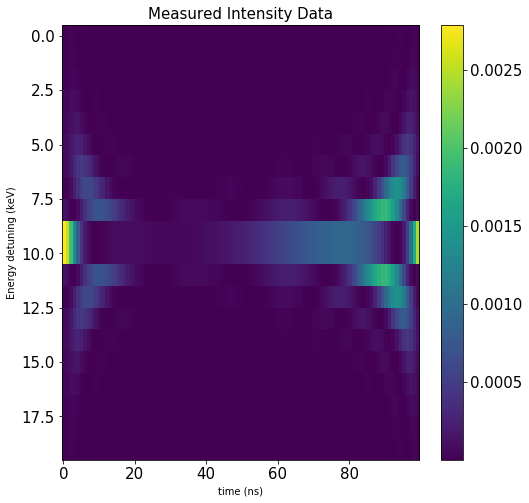

In [222]:
plt.figure(figsize=(8,8))
plt.title('Measured Intensity Data', fontsize=15)
plt.imshow(measured_data_list,interpolation='nearest',aspect='auto')
plt.xlabel('time (ns)', fontsize=10)
plt.ylabel('Energy detuning (keV)', fontsize=10)
plt.colorbar()
plt.show()

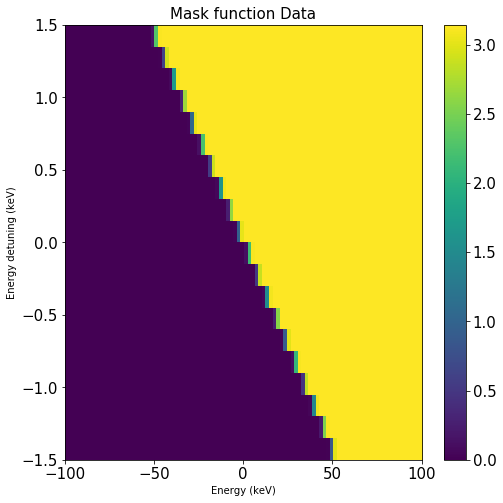

In [223]:
plt.figure(figsize=(8,8))
plt.xlabel('Energy (keV)', fontsize=10)
plt.ylabel('Energy detuning (keV)', fontsize=10)
plt.title('Mask function Data', fontsize=15)
plt.imshow(np.angle(mask_data_list),interpolation='nearest',aspect='auto', extent = [w[0] , w[-1], -1.5 , 1.5])
plt.colorbar()
plt.show()

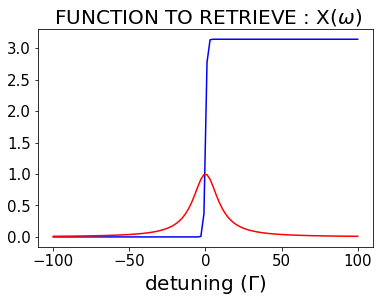

In [224]:
plt.figure(figsize=(8,8))
fig,ax= plt.subplots()
ax.plot(w, np.angle(sample_data), color = "blue")
ax.plot(w, np.abs(sample_data), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = " FUNCTION TO RETRIEVE : X($\omega$)")
plt.show()

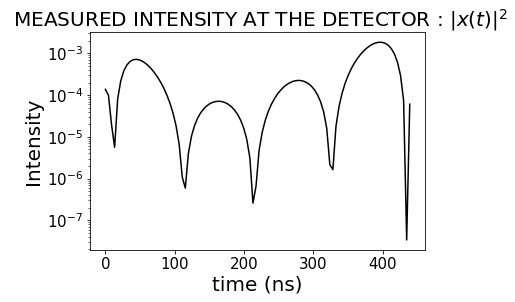

In [225]:
fig,ax= plt.subplots()

ax.semilogy(time_data,measured_data_list[11], color = "black")
#ax.plot(w, exp_phase)
#ax.set_xlim([0,800])
ax.set(xlabel = "time (ns)",
       ylabel = "Intensity",
       title = " MEASURED INTENSITY AT THE DETECTOR : $|x(t)|^2$")
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)

plt.show()

## cut off part of the measured graph

In [238]:
measured_data_list[:,np.where(time_data >200)] = 0


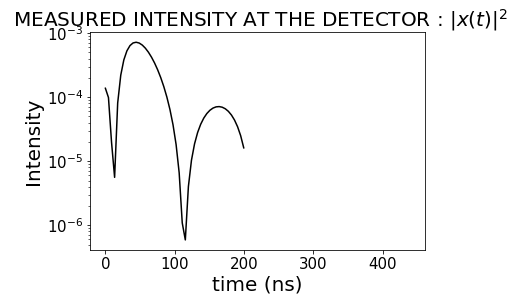

In [242]:
fig,ax= plt.subplots()

ax.semilogy(time_data,measured_data_list[11], color = "black")
#ax.plot(w, exp_phase)
#ax.set_xlim([0,800])
ax.set(xlabel = "time (ns)",
       ylabel = "Intensity",
       title = " MEASURED INTENSITY AT THE DETECTOR : $|x(t)|^2$")
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)

plt.show()

## STEEPEST DESCENT ALGORITHM

In [243]:
#function to implement Newton's method
def SteepestDescent2(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object) retrieved function of the object
        
        #Implement Steepest descent method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0  #initial guess of the object
    
    
    rho = np.zeros(max_iter) #to store the progression of the error function
    
    for n in range(0,max_iter-1):
        
        #1. find error and further gradient of error in the object guess 

        ###########calculate rho, drho, ddrho(Hessian)####################
  
        rho_n, Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
        
        #2. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        
        rho[n] = rho_n
        
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n, rho, n
        
        #3. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho, n
        
        #apply an update to object guess (obj_n):     
        
        p_n= -Drho_n #search direction for steepest descent
        
        
        
        obj_n = obj_n+beta*p_n #standard optimization algorithm update
        
        
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho, n

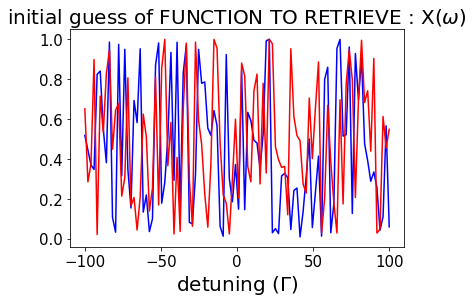

In [244]:

obj_0 = np.random.random(len(mask_data_list[0]))*np.exp(1j*np.random.random(len(mask_data_list[0])))
plt.figure(figsize=(8,8))
fig,ax= plt.subplots()
ax.plot(w, np.angle(obj_0), color = "blue")
ax.plot(w, np.abs(obj_0), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "initial guess of FUNCTION TO RETRIEVE : X($\omega$)")
plt.show()

In [248]:
#apply the steepest descent algorithm

# choice of 0<beta<1


beta,epsilon,max_iter=0.5,0.0001,10000
approx_obj,rho,run_iter = SteepestDescent2(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter) 
#print(approx_obj) #give the x for which p(x)=0

Exceeded maximum iterations. No solution found.


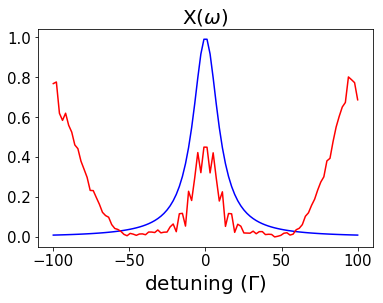

In [249]:
fig,ax= plt.subplots()
plt.figure(figsize=(25,25))
ax.plot(w, np.abs(sample_data), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "X($\omega$)")
plt.show()

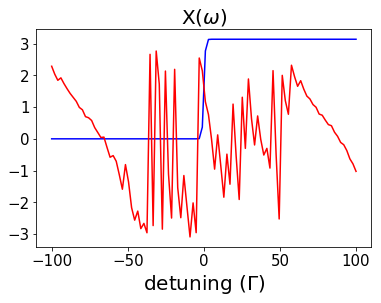

In [250]:
fig,ax= plt.subplots()
plt.figure(figsize=(25,25))
ax.plot(w, np.angle(sample_data), color = "blue")
ax.plot(w, np.angle(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "X($\omega$)")
plt.show()

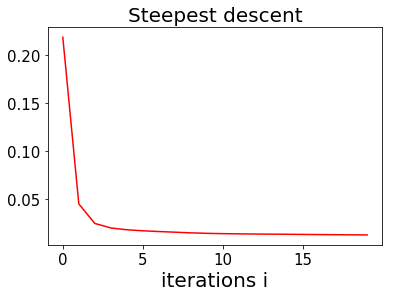

In [251]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho[0: 20], color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = "",
       title = "Steepest descent")
plt.show()